# Assess quality of single cell data from single-cell RNA sequencing of sandwich and dome culture data

In [1]:
%matplotlib inline

import os
import helper_functions_GSE164638 as hf

import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import shutil

<div class="alert alert-info">
    
# Navigating this notebook
*** ***
**Load data and set settings, parameters, and directories**
0. [Directories for input and output data](#step0)
1. [Plot functions and settings](#plot_settings)
2. [Data Processing Parameters](#pp_params)
3. [Input meta-data information](#metadata)
4. [Load raw data and make output folders](#load_data)
    <br>
    <br>
    
**Background Filtering**
5. [Filter out background based on UMIs/cell](#backgd_filter)
6. [Determine library quality based on reads and UMI stats](#lib_QC)<br>
    4.1 [Pseudo-Saturation Analysis](#psat_analysis)<br>
    4.2 [Percent reads aligned for each condition](#pct_reads_align)<br>
    4.3 [Determining read losses: total reads v. passing reads](#reads_total_v_pass)<br>
    4.4 [Summary of read stats](#reads_stats)<br>
    4.5 [Cell quality check](#cell_QC)<br>
    4.6 [Summary of cell quality](#cell_QC_summary)<br>
    <br>
    
**Save**
7. [Save the filtered h5ad files](#save_files)<br>
    
</div>  

*** ***

<a id='step0'></a>

## Directories for input and output data

In [2]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_filter_QC'
os.makedirs(plot_dir, exist_ok=True)

qc_dir = '_quality_control_stats/'
os.makedirs(qc_dir, exist_ok=True)

# Directory to inDrop.py output summary stats folder (containing per-cell-barcode number reads, UMIs, etc):
quants_dir = '_sc_data/quants/sandwich_dome/'

<a id='plot_settings'></a>

## Plot functions and settings

In [3]:
# Define a useful plotting function (adds a label to points)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [4]:
hf.set_plot_defaults(fontsize=36)
plt.rcParams.update(plt.rcParamsDefault)
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2.0)
sns.set_style('white')

<a id='pp_params'></a>

## Data Processing Parameters

In [5]:
# min number of UMIs per cell barcode, for separating 
# background from real cells
default_min_tot = 500  

# max fraction of UMIs from mitochondrial genes, for 
# separating live and dead cells
default_max_mito_frac = 0.15 

<a id='metadata'></a>

## Input meta-data information

In [6]:
# Define the experimental data files and their associated metadata labels (experiment, batch, condition...)
# `meta_keys` lists the names of the columns to be added to the .obs dataframe.
# For each key in `meta_keys`, there must be a corresponding entry in the 
# `meta_values` list for each sample.
# Use key 'new name' if you want to convert the original sample IDs into more
# meaningful sample names.
Expt_Name = 'Sandwich v Dome'
meta_keys = ['condition', 'batch']
meta_values = {'Dome-R1-2.1': ['Dome', 2],
             'Dome-R1-2.2': ['Dome', 2],
             'Dome-R1-2.3': ['Dome', 2], 
             'Dome-R1-2.4': ['Dome', 2], 
             'Sand-R2-1.1': ['Sandwich', 1]}
# NB - best practice - record in meta_values the experimental IDs used in lab notebook, to allow cross-referencing


# Point to where the data is sitting
# Currently, the meta_values keys are the names of the expeirmental data sets
# If this changes, can add a field to meta_values that records the file location for each expeirment
# '1.1' for 1.1.counts.tsv.gz counts file
input_paths = {
    'sc_data/counts': list(meta_values.keys())
}

<a id='load_data'></a>

## Load raw data and make output folders

### Read in quant metrics file to compare reads to UMIs

In [7]:
# decompress the gzipped files
# make a dictionary of the quant metrics data with the library names as keys
# add quant metrics as dataframe as values for dictionary keys
# generate new aligned reads columns for comparison to UMIs

Dq = {} # Quants metrics dictionary - will be using this to assess quality

for file in os.listdir(quants_dir):
    filename = os.fsdecode(file)
    filename = filename.split(".tsv.gz")[0]
    lib_name = filename.split(".quant")[0]
    if file.endswith(".gz"):
        with gzip.open('{}/{}.tsv.gz'.format(quants_dir, filename), 'r') as f_in, open('{}/{}.tsv'.format(quants_dir, filename), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        if lib_name in filename:
            df_q = pd.read_csv('{}/{}.tsv'.format(quants_dir, filename), sep="\t")
            Dq['{}'.format(lib_name)] = df_q
            df_q['Aligned Reads'] = df_q['Reads'] - df_q['Reads with no alignments']
        else:
            continue

### Load raw counts matrices from indrops.py pipeline (.tsv files), saving .h5ad files for faster loading in the future

In [8]:

sample_list = [] # This will become a copy of the list of meta keys
D = {} # This will be the main data structure - a dictionary wiht counts matrices as values, and meta keys as keys
os.makedirs(h5ad_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

for iFold, folder in enumerate(input_paths):
    for orig_name in input_paths[folder]:
        meta_dict = {k: meta_values[orig_name][i] for i,k in enumerate(meta_keys)}
        
        if 'new name' in meta_keys:
            new_name = meta_dict['new name']
        else:
            new_name = orig_name    
        sample_list.append(new_name)
        
        h5ad_filename = f'{h5ad_dir}/{new_name}-raw.h5ad'
        if os.path.exists(h5ad_filename):
            D[new_name] = sc.read(h5ad_filename)
        else:
            X, barcodes, genes = hf.load_annotated_text(
                hf.file_opener(f'{folder}/{orig_name}.counts.tsv.gz'),
                delim='\t',
                read_row_labels=True,
                read_column_labels=True
            )
            
            D[new_name] = sc.AnnData(X)
            D[new_name].obs_names = barcodes
            D[new_name].var_names = genes
            D[new_name].var_names_make_unique()
            del X, barcodes, genes
                        
            D[new_name].uns['min_tot'] = default_min_tot
            D[new_name].uns['max_mito'] = default_max_mito_frac
            
            for k,v in meta_dict.items():
                if k != 'new name':
                    D[new_name].obs[k] = v
                    
            D[new_name].write_h5ad(h5ad_filename, compression='gzip', force_dense=False)

        print('Loaded {}: {} barcodes, {} genes'.format(new_name, *D[new_name].shape))

Loaded Dome-R1-2.1: 12692 barcodes, 40931 genes
Loaded Dome-R1-2.2: 36954 barcodes, 40931 genes
Loaded Dome-R1-2.3: 29654 barcodes, 40931 genes
Loaded Dome-R1-2.4: 26632 barcodes, 40931 genes
Loaded Sand-R2-1.1: 38957 barcodes, 40931 genes


In [9]:
# add the number of reads to the annData object for each barcode
for s in D.keys():
    D[s].obs['reads'] = D[s].obs.index.map(Dq[s].set_index('Barcode')['Reads'].to_dict())
    D[s].obs['aligned reads'] = D[s].obs.index.map(Dq[s].set_index('Barcode')['Aligned Reads'].to_dict())

In [10]:
# specify gene list for dataset
gene_list = D[new_name].var_names.values.astype(str)

*** ***

<a id='backgd_filter'></a>

## Filter out background based on UMIs/cell
### First, plot histograms to help choose custom filtering thresholds
No filtering is actually done here, just checking that the total UMIs threshold is appropriate for each library. The threshold should lie between the two modes of the histogram, where the left mode corresponds to background and the right to real cells. Also check that (roughly) the expected number of cells are passing the filter.

No handles with labels found to put in legend.


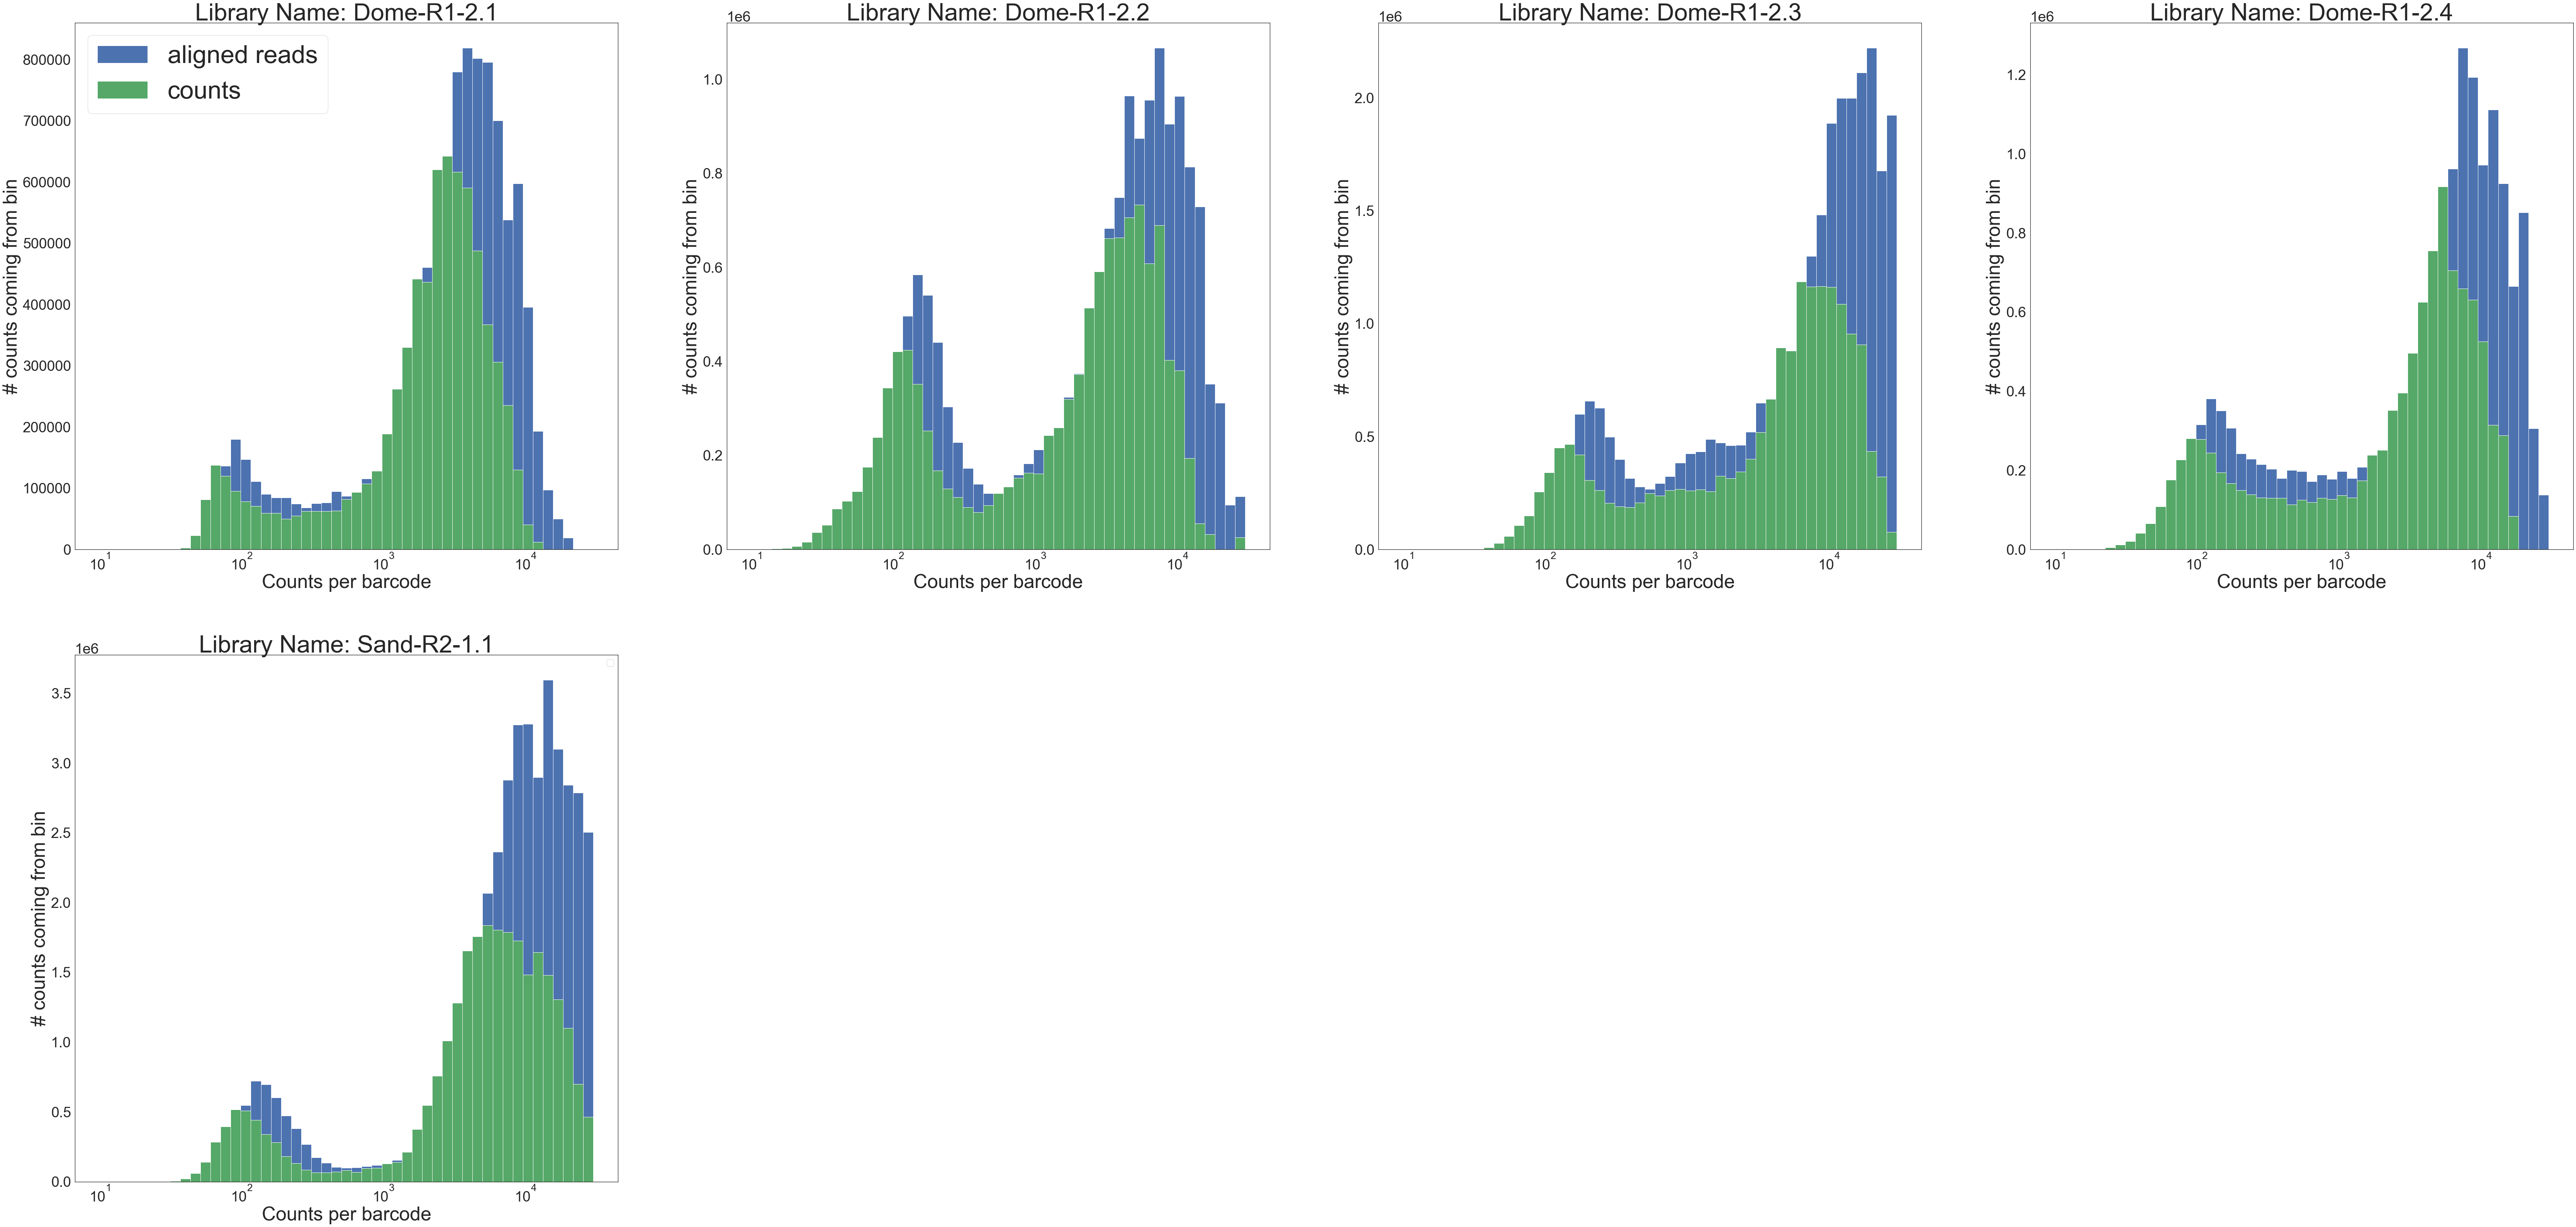

In [11]:
# Set some custom plotting parameters to adjust for subplots
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams.update({'font.size': 36})

# Start figure
fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=20, n_columns=4, fig_width=46, dpi=75)

for iS,s in enumerate(sample_list):
    # Loop over each library, plotting histogram of total counts (UMIs) per cell
    # Set subplot
    ax = plt.subplot(nrow, ncol, iS+1)
    
    # Calculate total counts per cells (row sums of counts matrix)
    D[s].obs['n_counts'] = D[s].X.sum(1).A.squeeze()
    
    # Plot the histogram
    hf.total_counts_histogram(Dq[s]['Aligned Reads'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=True, color='b')
    hf.total_counts_histogram(D[s].obs['n_counts'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=True, color='g')
    ax.set_title(f'Library Name: {s}', fontsize=60)
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    if iS == 0:
        ax.legend(('aligned reads', 'counts'), loc='best', fontsize='xx-large')

plt.subplots_adjust(bottom=2.5, right=2.0, top=3.5)
plt.legend()
plt.show()

<div class="alert alert-info">

**Plot Key:**
* **Blue** - total mapped reads per barcode
* **Green** - UMI-corrected counts per barcode

</div>  

## Define custom filtering thresholds based on inspection of above plots

In [12]:
# Change total count thresholds based on the histograms. 
# If a library is not included below, the default threshold is used.
D['Dome-R1-2.1'].uns['min_tot'] = 1000
D['Dome-R1-2.2'].uns['min_tot'] = 1000
D['Dome-R1-2.3'].uns['min_tot'] = 1000
D['Dome-R1-2.4'].uns['min_tot'] = 1000
D['Sand-R2-1.1'].uns['min_tot'] = 1000

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


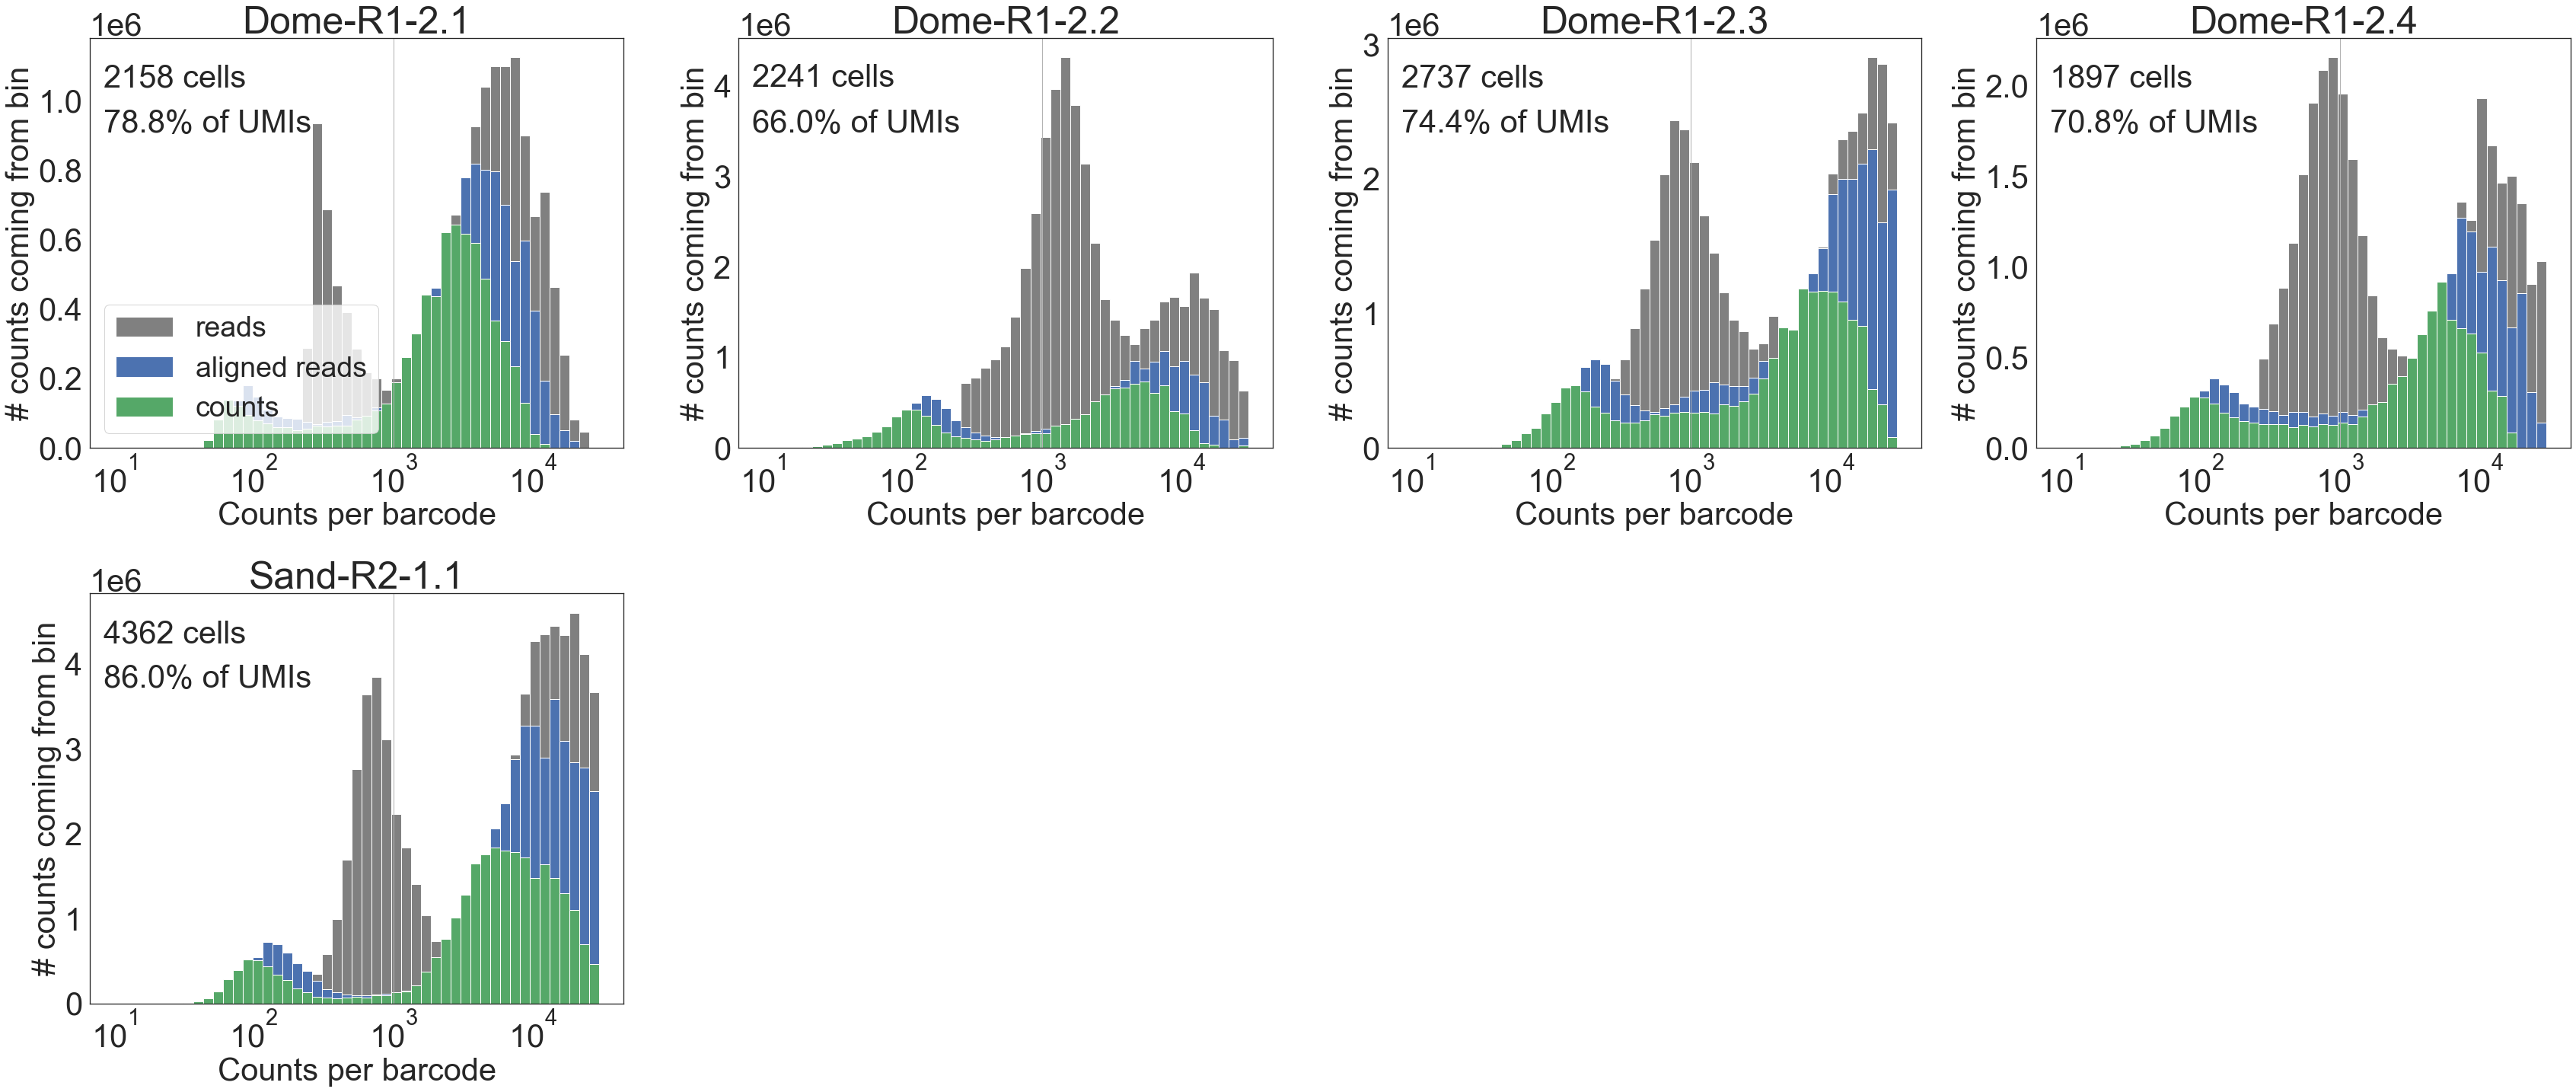

In [13]:
saving = True

# Set some custom plotting parameters to adjust for subplots
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
#plt.rcParams.update({'font.size': 36})

#some metrics we want to save:
bc_pass = {}
umi_pass = {}
reads_pass = {}

# Start figure
fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=10, n_columns=4, fig_width=46, dpi=75)

for iS,s in enumerate(sample_list):
    # Loop over each library, plotting histogram of total counts (UMIs) per cell
    
    # Set subplot
    ax = plt.subplot(nrow, ncol, iS+1)
    
    # Calculate total counts per cells (row sums of counts matrix)
    D[s].obs['n_counts'] = D[s].X.sum(1).A.squeeze()

    # Get minimum total counts threshold. Barcodes with 
    # total counts >= min_tot are considered real cells. 
    min_tot = D[s].uns['min_tot']
    
    # Plot the histogram
    hf.total_counts_histogram(D[s].obs['reads'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=True, color='gray')
    hf.total_counts_histogram(D[s].obs['aligned reads'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=True, color='b')
    hf.total_counts_histogram(D[s].obs['n_counts'], min_bin=10, max_bin=3e4, ax=ax, counts_per_bin=True, color='g')
    ax.set_title(f'{s}', fontsize=48)
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    if iS == 0:
        ax.legend(('reads', 'aligned reads', 'counts'), loc='lower left', fontsize=36)
    
    # Plot the threshold    
    ax.plot(min_tot * np.ones(2), yl, c=.7*np.ones(3), linewidth=1)
    
    # Calculate number of barcodes and pct of UMIs passing filter and show on plot
    mask = D[s].obs['n_counts'].values >= min_tot
    
    #add obs column which lets you know whether or not that particular barcode was included after filtering
    D[s].obs['included after filter'] = mask
    
    #ntot = total bcs
    #npass = cells passing filter step
    ntot = D[s].shape[0]
    npass = mask.sum()
    #print("total barcodes:", ntot, "passing barcodes:", npass)
    
    #umis passing filter step
    umitot = D[s].obs['n_counts'].values.sum()
    umipass = D[s].obs['n_counts'].values[mask].sum()
    #print("total umis:", umitot, "passing umis:", umipass)
    
    #reads passing filter step --> #ADD READSPASS_ALIGNED
    readstot = D[s].obs['reads'].values.sum()
    reads_aligned = D[s].obs['aligned reads'].values.sum()
    readspass = (D[s].obs['reads'].loc[D[s].obs['included after filter'] == True]).sum()
    umis_per_cell = umipass/npass

    # For each sample s, the number of cell barcodes passing filter, total barcode number, and ratio
    bc_pass[s] = npass, ntot, npass/ntot 
    
    # For each sample s, the number of UMIs passing filter, total number UMIs, and ratio
    umi_pass[s] = umipass, umitot, umipass/umitot, umis_per_cell
    
    # For each sample s, the number of reads passing filter, total number reads, and ratio
    reads_pass[s] = readspass, readstot, reads_aligned, readspass/readstot
    
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.88, '{} cells'.format(npass), fontsize=40)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.77, '{:.1f}% of UMIs'.format(umipass/umitot*100), fontsize=40)

plt.subplots_adjust(bottom=2.5, right=2.0, top=3.5)   
fig.tight_layout()

if saving:
    plt.savefig(f'{plot_dir}/background_filtering_sand_dome.eps')
plt.show()

<div class="alert alert-info">

* **Gray** - total reads per barcode (including non-aligned)
* **Blue** - total mapped reads per barcode
* **Green** - UMI-corrected counts per barcode

The vertical line shows the threshold applied to the UMI-corrected counts only

</div>  

<a id='lib_QC'></a>

## Determine library quality based on reads and UMI stats

In [14]:
def make_qc_dict(bc_pass, umi_pass, reads_pass, filename):
    '''
    Makes pandas dataframe of quality control information and saves it as a csv file.
    
    Arguments:
    
    bc_pass: dict
        contains passing barcodes for each library
    umi_pass: dict
        contains passing umis for each library
    reads_pass: dict
        contains passing reads for each library
    filename: string
        name of the .csv file you want to save for the quality control information.
        
    Returns: 
    
    qc_df: dataframe
        pandas dataframe with quality control information for each library as well as metadata
    
    '''
    # 0. Set floats to 3 decimal places and use scientific notation
    pd.set_option('display.float_format', '{:.3g}'.format)
    
    # 1. Reformat inputs as pandas dataframes, set the values to float types:
    bcpass = pd.DataFrame.from_dict(bc_pass, orient='index', columns=['npass', 'ntot', 'npass/ntot'], dtype='float')
    #bcpass.index.names = ['sample']
    umipass = pd.DataFrame.from_dict(umi_pass, orient='index', columns=['umipass','umitot','umipass/umitot', 'umis_per_cell'], dtype='float')
    readspass = pd.DataFrame.from_dict(reads_pass, orient='index', columns=['aligned reads','readstot','readspass', 'readspass/readstot'], dtype='float')

    # 2. Concatenate the QC data in the dataframes into a new dataframe called bc_umi_reads_pass:
    bc_umi_reads_pass = pd.concat([bcpass, umipass, readspass], axis=1)
    bc_umi_reads_pass['#barcodes_pass_(#cells)/total_#barcodes'] = bc_umi_reads_pass['npass']/bc_umi_reads_pass['ntot']
    bc_umi_reads_pass['#reads_pass/total_#reads'] = bc_umi_reads_pass['readspass']/bc_umi_reads_pass['readstot']
    bc_umi_reads_pass['average_(passing)_#UMIs_per_cell'] = bc_umi_reads_pass['umipass']/bc_umi_reads_pass['npass']
    bc_umi_reads_pass['average_total_#reads_per_cell'] = bc_umi_reads_pass['readstot']/bc_umi_reads_pass['npass']
    
    # 3. Add experimental design meta data to pandas data frame:
    # 3.1 Reformat the meta values into a panda dataframe format:
    meta_df = pd.DataFrame.from_dict(meta_values)
    meta_df_T = meta_df.transpose()
    meta_df_T = meta_df_T.rename(columns={i: meta_keys[i] for i in range(len(meta_keys))})
    # 3.2 Merge the meta data frame with the QC dataframe
    run_info_df = pd.merge(meta_df_T, bc_umi_reads_pass, left_index=True, right_index=True)

        
    # 4. Rename columns:
    qc_df = run_info_df.rename(columns = {'avgUmiperCell' : 'average_(passing)_#UMIs_per_cell',
                                          'npass': '#barcodes_pass_(#cells)', 
                                          'ntot': 'total_#barcodes', 
                                          'npass/ntot' : 'passing_#UMIs/total_#UMIs', 
                                          'readstot':'total_#reads', 
                                          'umipass': 'passing_#UMIs', 
                                          'umitot': 'total_#UMIs', 
                                          'readspass': '#reads_pass', 
                                          'readstot' : 'total_#reads', 
                                          'aligned reads': 'total_#aligned_reads'})


    # 5. Generate additional synthesized outputs:
    qc_df['Library Name'] = qc_df.index
    lib_name = qc_df['Library Name'].str.split('.', n=1, expand=True)
    
    qc_df['%passing_barcodes'] = qc_df['#barcodes_pass_(#cells)/total_#barcodes']*100
    qc_df['%passing_UMIs'] = qc_df['passing_#UMIs']/qc_df['total_#UMIs']*100
    qc_df['%passing_reads'] = qc_df['#reads_pass/total_#reads']*100
    qc_df['%aligned_reads'] = (qc_df['total_#aligned_reads']/qc_df['total_#reads'])*100
    qc_df['#passing_reads/passing_UMI'] = qc_df['#reads_pass']/qc_df['passing_#UMIs']
    qc_df['average_#aligned_(mapped)_reads_per_cell'] = qc_df['total_#aligned_reads']/ qc_df['#barcodes_pass_(#cells)']
    qc_df['#reads_pass/#barcodes_pass_(#cells)'] = qc_df['#reads_pass']/ qc_df['#barcodes_pass_(#cells)']
    
    qc_df.to_csv(filename,index=True, index_label= 'Library Name', float_format='%.3g')
    
    return qc_df

In [15]:
qc_df = make_qc_dict(bc_pass, umi_pass, reads_pass, qc_dir+'/QC_sand_dome.csv')

In [16]:
qc_df['Library ID'] = qc_df.index

<a id='psat_analysis'></a>

### Pseudo-Saturation Analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


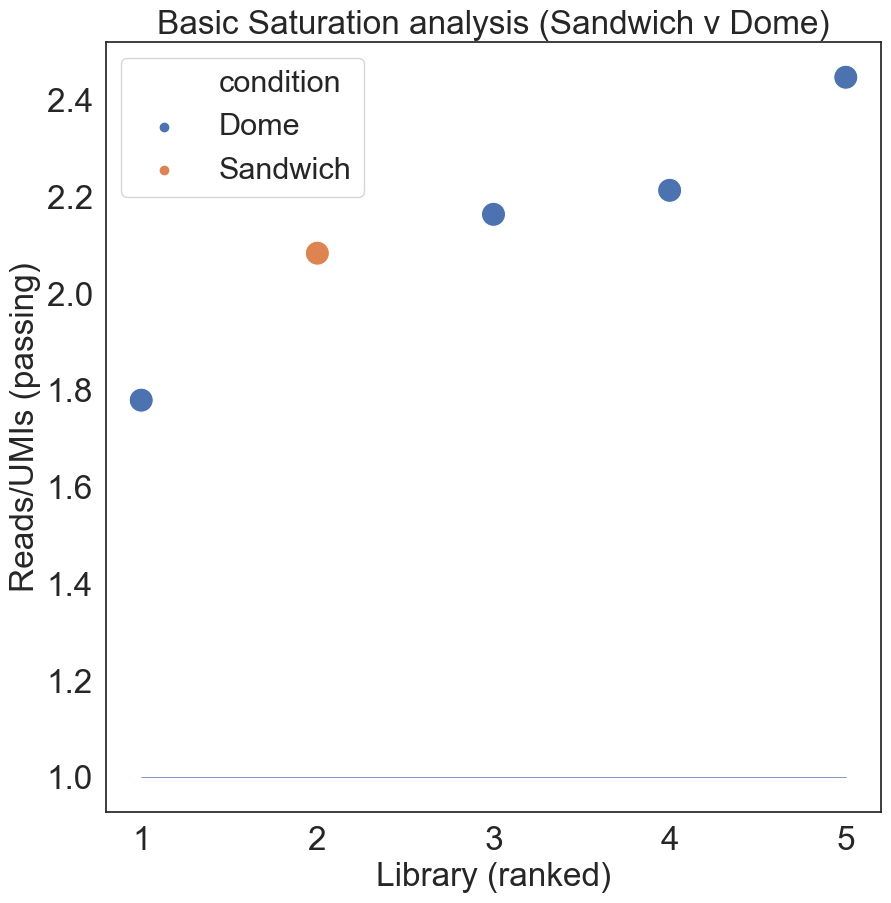

In [17]:
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

sns.scatterplot(qc_df['#passing_reads/passing_UMI'].rank(), 
                qc_df['#passing_reads/passing_UMI'], 
                hue= qc_df['condition'],
                s=300)

# For troubleshooting, useful to add sample ID labels to points 
# Toggle to 1 to add labels, 0 to remove them:
if 0:
    label_point(qc_df['#passing_reads/passing_UMI'].rank(), 
                qc_df['#passing_reads/passing_UMI'],
                qc_df['Library ID'], plt.gca()) 

# Add annotations:    
plt.plot([1, qc_df['#passing_reads/passing_UMI'].rank().max()], [1, 1], linewidth=0.5) # Line at 1
plt.xlabel("Library (ranked)",fontsize=24)
plt.ylabel("Reads/UMIs (passing)",fontsize=24)
plt.title("Basic Saturation analysis ("+Expt_Name +")",fontsize=24)

plt.savefig(f'{plot_dir}/readsperUMI_v_rank_ReadsperUMI_sand_dome.eps')
plt.show()

<a id='pct_reads_align'></a>

### Percent reads aligned for each condition

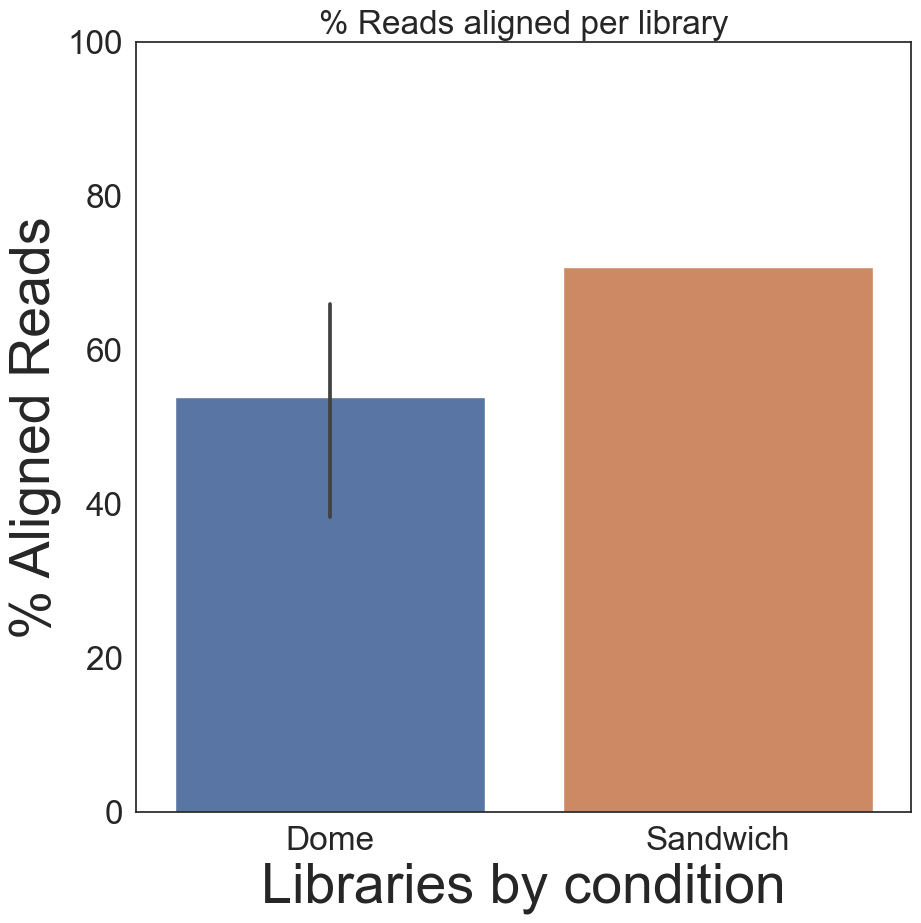

In [18]:
sns.barplot(x=qc_df['condition'], y=qc_df['%aligned_reads'])

plt.title("% Reads aligned per library")
plt.xlabel("Libraries by condition")
plt.ylabel("% Aligned Reads")
plt.ylim(0,100)
plt.savefig(f'{plot_dir}/libraries_passing_alignment_filter_sand_dome.eps')
plt.show()

<a id='reads_total_v_pass'></a>

### Determining read losses: total reads v. passing reads

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


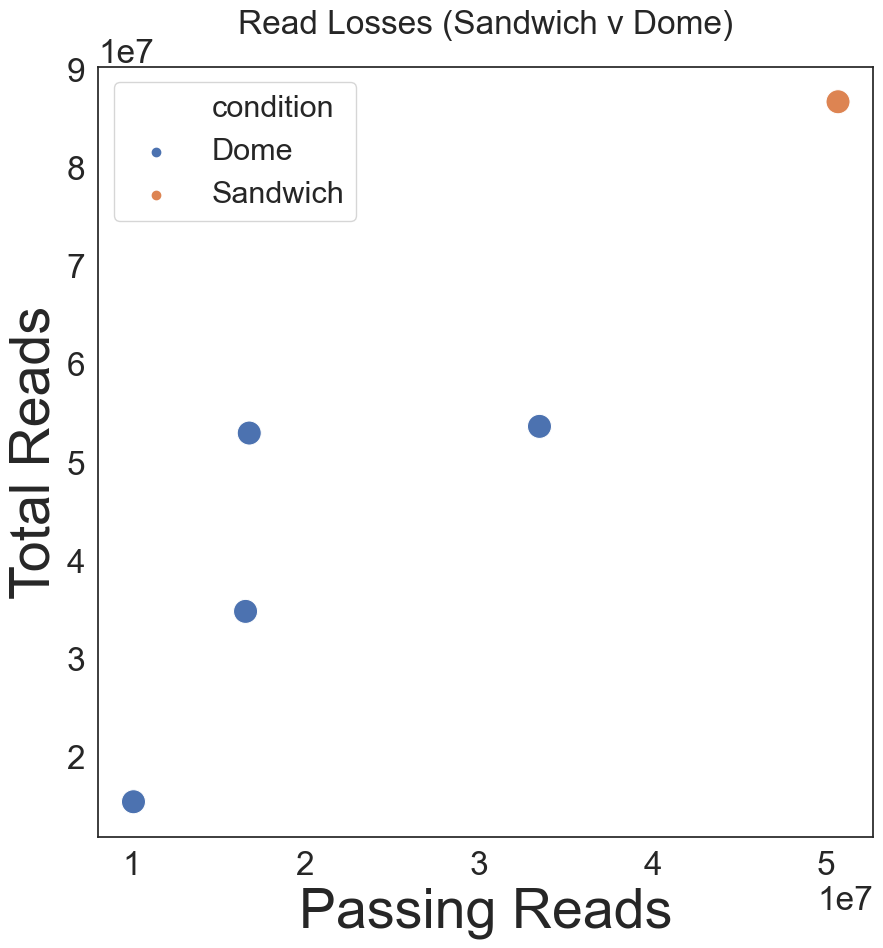

In [19]:
g = sns.scatterplot(x=qc_df['#reads_pass'], y=qc_df['total_#reads'], hue= qc_df['condition'], s=300)
# Toggle to 1 to add labels, 0 to remove them:
if 0:
    label_point(qc_df['#reads_pass'], 
                qc_df['total_#reads'], 
                qc_df['batch'], plt.gca()) 


plt.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
plt.title("Read Losses ("+Expt_Name +")",fontsize=24, pad=24)
plt.xlabel("Passing Reads")
plt.ylabel("Total Reads")
plt.savefig(f'{plot_dir}/reads_pass_v_total_reads_scatter_label_sand_dome.eps')
plt.show()

<a id='reads_stats'></a>

### Summary of read stats

In [20]:
print('{:20s}{:>25s}{:>25s}'.format('Library ID', '% aligned reads', '% passing reads'))

for s in list(qc_df['Library ID'].unique()):
    aligned = float(qc_df['%aligned_reads'].loc[qc_df['Library Name'] == s])
    passing = float(qc_df['%passing_reads'].loc[qc_df['Library Name'] == s])
    
    print('{:20s}{:>25.2f}%{:>25.2f}%'.format(s, aligned, passing))

Library ID                    % aligned reads          % passing reads
Dome-R1-2.1                             69.97%                    65.54%
Dome-R1-2.2                             34.73%                    31.68%
Dome-R1-2.3                             61.99%                    62.46%
Dome-R1-2.4                             48.71%                    47.60%
Sand-R2-1.1                             70.74%                    58.49%


<a id='cell_QC'></a>

## Cell quality check

### Cells passing filter

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


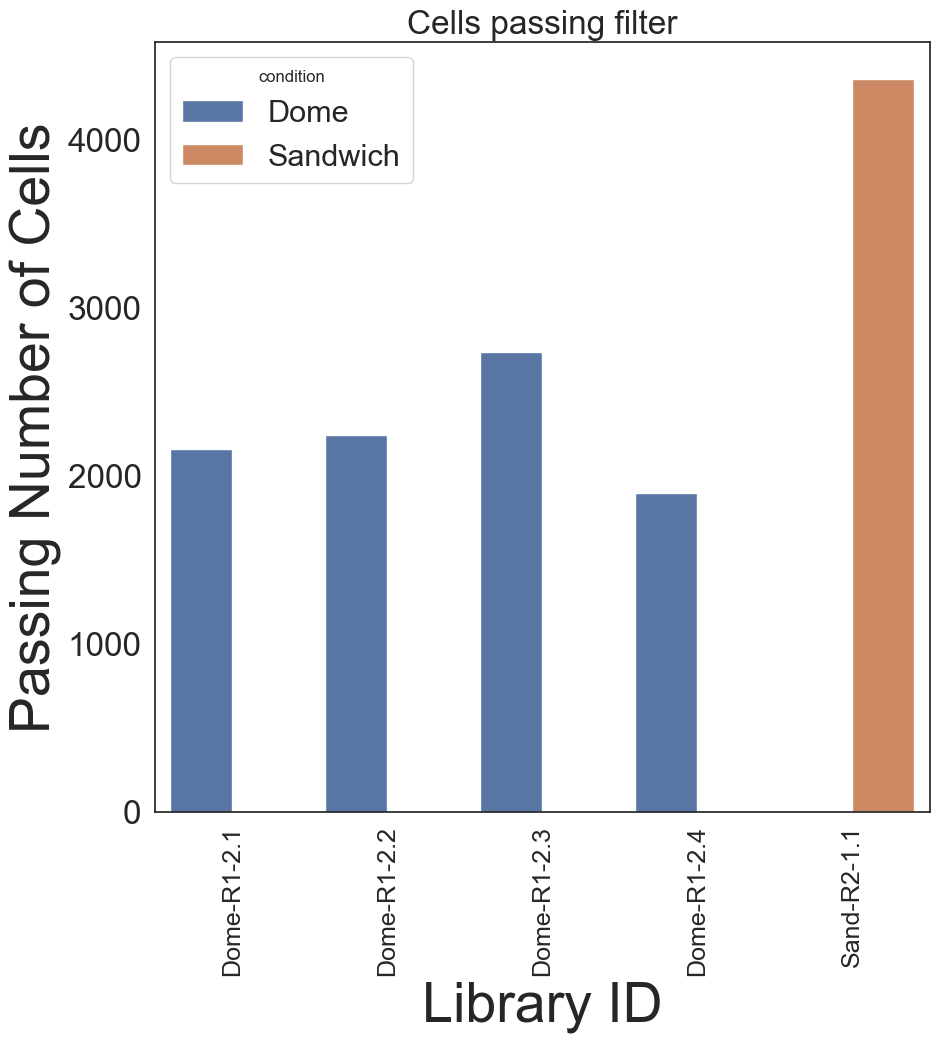

In [21]:
saving = True

ax = sns.barplot(x=qc_df['Library ID'], y=qc_df['#barcodes_pass_(#cells)'], hue=qc_df['condition'])
plt.xlabel('Library ID')
plt.ylabel('Passing Number of Cells')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, rotation=90) # overlapping with current fontsize so change to smaller fontsize
plt.title('Cells passing filter')

if saving:
    plt.savefig(f'{plot_dir}/cells_passing_filter_sand_dome.eps') 
plt.show()

### Passing cells v. percent passing UMIs per library

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


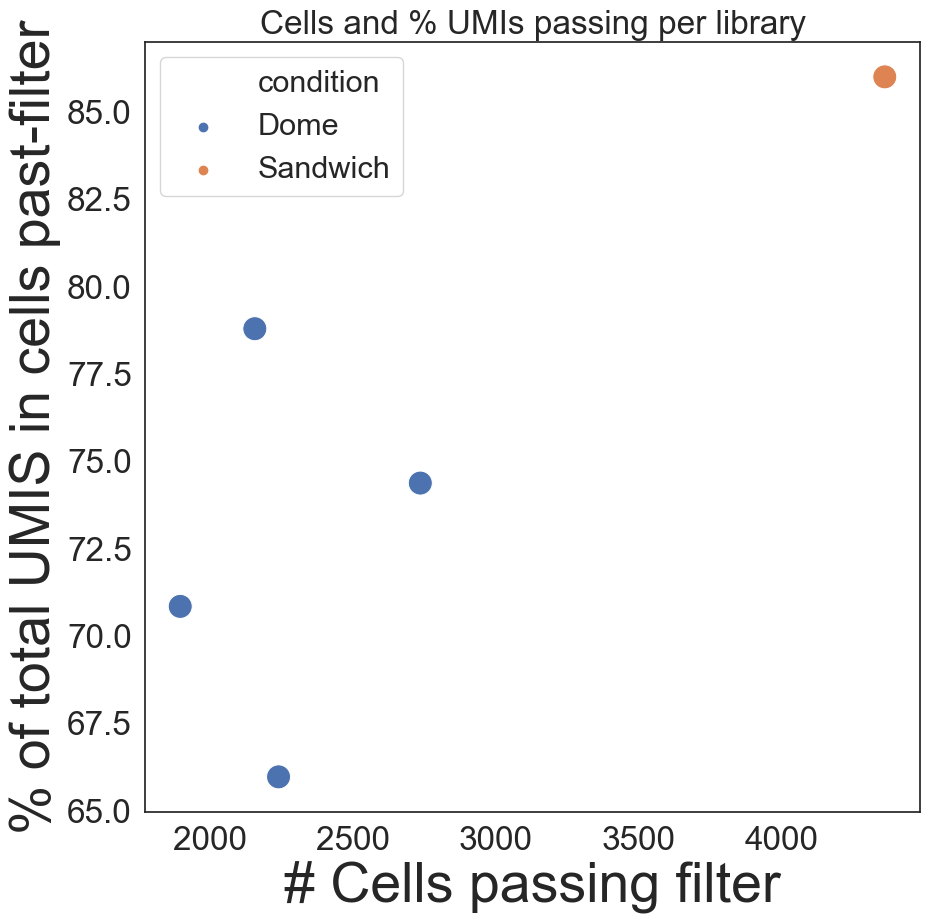

In [22]:
sns.scatterplot(qc_df['#barcodes_pass_(#cells)'], qc_df['%passing_UMIs'], hue=qc_df['condition'], s=300)

# Toggle to 1 to add labels, 0 to remove them:
if 0:
    label_point(qc_df['#barcodes_pass_(#cells)'], 
                qc_df['%passing_UMIs'], 
                qc_df['batch'], plt.gca()) 

plt.xlabel('# Cells passing filter')
plt.ylabel('% of total UMIS in cells past-filter')
plt.title('Cells and % UMIs passing per library')
plt.savefig(f'{plot_dir}/cells_and_%_UMIs_passing_per_library_sand_dome.eps')
plt.show()

<a id='cell_QC_summary'></a>

### Summary of barcode stats (passing cells)

In [23]:
print('{:20s}{:>25s}{:>25s}'.format('Sample', '# barcodes pre-filter', '# barcodes post-filter'))

for s in sample_list:
    keep = D[s].obs['n_counts'] >= D[s].uns['min_tot']
    D[s] = D[s][keep]
    
    n_orig = len(keep)
    n_pass = keep.sum()
    print('{:20s}{:>25}{:>25}'.format(s, n_orig, n_pass))

Sample                  # barcodes pre-filter   # barcodes post-filter
Dome-R1-2.1                             12692                     2158
Dome-R1-2.2                             36954                     2241
Dome-R1-2.3                             29654                     2737
Dome-R1-2.4                             26632                     1897
Sand-R2-1.1                             38957                     4362


*** ***

<a id='save_files'></a>

## Save the filtered h5ad files

In [24]:
for s in sample_list:
    D[s].write_h5ad(f'{h5ad_dir}/{s}-filtered.h5ad', compression='gzip', force_dense=False)

/Users/hailey/anaconda3/lib/python3.8/site-packages/anndata/_io/h5ad.py:58: FutureWarning: The `force_dense` argument is deprecated. Use `as_dense` instead.
  warn(


In [25]:
# To load the filtered files at a later point:
sample_list = ['Dome-R1-2.1', 'Dome-R1-2.2', 'Dome-R1-2.3', 'Dome-R1-2.4', 'Sand-R2-1.1']
D = {}
for s in sample_list:
    D[s] = sc.read(f'{h5ad_dir}/{s}-filtered.h5ad')
gene_list = D[s].var_names.values.astype(str)